In [94]:
from numpy import load

circuit1_npz = load('./Circuit1/spectrum-f_min_0-f_max_12501-f_step_250.npz')
circuit2_npz = load('./Circuit2/spectrum-f_min_0-f_max_12501-f_step_250.npz')

circuit1_npz_array = circuit1_npz['arr_0']
circuit2_npz_array = circuit2_npz['arr_0']

with open(f'circuit1_data.csv', 'w') as f:
        f.write('Frequency,Z_real,Z_imag\n')
with open(f'circuit2_data.csv', 'w') as f:
        f.write('Frequency,Z_real,Z_imag\n')

for i in range(0, len(circuit1_npz_array)):
    frequency = i * 250
    with open(f'circuit1_data.csv', 'a') as f:
        real_part = circuit1_npz_array[i][0].real
        imag_part = circuit1_npz_array[i][0].imag
        f.write(f"{frequency},{real_part},{imag_part}\n")

    with open(f'circuit2_data.csv', 'a') as f:
        real_part = circuit2_npz_array[i][0].real
        imag_part = circuit2_npz_array[i][0].imag
        f.write(f"{frequency},{real_part},{imag_part}\n")

In [95]:
import numpy as np
import random
import pandas as pd

def log_likelihood(Z_i, omega_i, R, C, sigma):
    """
    Calculates the likelihood of observing the measured impedance data given 
    a specific circuit model and its parameters.

    Args:
        Z_i (complex): Measured impedance at frequency omega_i.
        omega_i (float): Angular frequency.
        R (list): List of resistance values in the circuit model.
        C (list): List of capacitance values in the circuit model.
        sigma (float): Standard deviation of the measurement noise.

    Returns:
        float: Likelihood value.
    """
    
    # Calculate impedance from the circuit model
    z_omega_i = circuit_impedance(omega_i, R, C)
    log_likelihood_value = -(1 / (2 * sigma**2)) * abs(Z_i - z_omega_i)**2 - np.log(np.sqrt(2 * np.pi * sigma**2))

    return log_likelihood_value  # Return the log-likelihood

def circuit_impedance(omega_i, R, C):
    """
    Calculates the impedance of the circuit model at a given frequency.

    Args:
        omega_i (float): Angular frequency.
        R (list): List of resistance values in the circuit model.
        C (list): List of capacitance values in the circuit model.

    Returns:
        complex: Impedance of the circuit model.
    """
    
    # This is a placeholder for the actual impedance calculation.
    # You'll need to replace this with the correct formula for your circuit model.
    # For example, for a simple RC circuit:
    # z_omega_i = R[0] / (1 + 1j * omega_i * R[0] * C[0])  
    
    # For the circuits in your assignment, you'll need to use the impedance formulas
    # for parallel RC circuits connected in series.
    z_omega_i = 0
    for i in range(len(R)):  # Assuming len(R) == len(C)
        z_omega_i += R[i] / (1 + 1j * omega_i * R[i] * C[i])
    
    return z_omega_i

def log_prior(R, C, R_min=100, R_max=10e3, C_min=10e-9, C_max=10e-6):
    """
    Calculates the prior probability of the circuit parameters.

    Args:
        R (list): List of resistance values.
        C (list): List of capacitance values.
        R_min (float, optional): Minimum resistance value. Defaults to 100.
        R_max (float, optional): Maximum resistance value. Defaults to 10e3.
        C_min (float, optional): Minimum capacitance value. Defaults to 10e-9.
        C_max (float, optional): Maximum capacitance value. Defaults to 10e-6.

    Returns:
        float: Prior probability value.
    """
    
    for r in R:
        if not (R_min <= r <= R_max):
            return -np.inf  # Prior is 0 if resistance is outside the allowed range
    for c in C:
        if not (C_min <= c <= C_max):
            return -np.inf  # Prior is 0 if capacitance is outside the allowed range
    
    # If all parameters are within the allowed range, use uniform prior
    return 0  # Log of a uniform distribution is 0  

def log_posterior(omega_n, Z_n, K, R, C, sigma):
    """
    Calculates the posterior probability of the circuit parameters given the 
    observed data and the prior.

    Args:
        omega_n (list): List of angular frequencies.
        Z_n (list): List of measured impedances.
        K (int): Number of RC parallel circuits in the model.
        R (list): List of resistance values.
        C (list): List of capacitance values.
        sigma (float): Standard deviation of the measurement noise.

    Returns:
        float: Posterior probability value.
    """   
    log_prior_prob = log_prior(R, C)
    if log_prior_prob == -np.inf:
        return -np.inf  # If log-prior is -inf, log-posterior is also -inf

    log_likelihood_prob = 0
    for i in range(len(omega_n)):
        log_likelihood_prob += log_likelihood(Z_n[i], omega_n[i], R, C, sigma)

    log_posterior_prob = log_likelihood_prob + log_prior_prob
    return log_posterior_prob  # Return the un-logged posterior probability


def metropolis(omega_n, Z_n, K, sigma, n_iterations=10000, burn_in=1000, 
              R_min=100, R_max=10e3, C_min=10e-9, C_max=10e-6):
    """
    Performs Metropolis sampling to estimate the circuit parameters.

    Args:
        omega_n (list): List of angular frequencies.
        Z_n (list): List of measured impedances.
        K (int): Number of RC parallel circuits in the model.
        sigma (float): Standard deviation of the measurement noise.
        n_iterations (int, optional): Number of MCMC iterations. Defaults to 10000.
        burn_in (int, optional): Number of initial samples to discard. Defaults to 1000.
        R_min (float, optional): Minimum resistance value. Defaults to 100.
        R_max (float, optional): Maximum resistance value. Defaults to 10e3.
        C_min (float, optional): Minimum capacitance value. Defaults to 10e-9.
        C_max (float, optional): Maximum capacitance value. Defaults to 10e-6.

    Returns:
        tuple: A tuple containing the accepted R and C samples.
    """

    # Initialize parameters
    R_current = [random.uniform(R_min, R_max) for _ in range(K)]
    C_current = [random.uniform(C_min, C_max) for _ in range(K)]
    accepted_proposals = 0
    # Store accepted samples
    R_samples = []
    C_samples = []
    
    for _ in range(n_iterations):
        # Propose new parameters
        R_proposal = [r + random.uniform(-10, 10) for r in R_current]
        C_proposal = [c + random.uniform(-10e-9, 10e-9) for c in C_current]

        # Calculate posterior probabilities
        log_posterior_current = log_posterior(omega_n, Z_n, K, R_current, C_current, sigma)
        log_posterior_proposal = log_posterior(omega_n, Z_n, K, R_proposal, C_proposal, sigma)

        # Calculate log of acceptance ratio
        log_acceptance_ratio = log_posterior_proposal - log_posterior_current
        acceptance_ratio = min(0, log_acceptance_ratio)  # 0 if log_acceptance_ratio is positive, else log_acceptance_ratio

        # Accept or reject proposal (using exp(acceptance_ratio) since acceptance_ratio is in log space)
        if np.log(random.uniform(0, 1)) < acceptance_ratio:
            R_current = R_proposal
            C_current = C_proposal
            accepted_proposals += 1
        # Store accepted samples after burn-in
        if _ > burn_in:
            R_samples.append(R_current)
            C_samples.append(C_current)

    return R_current, C_current, accepted_proposals, R_samples, C_samples

data = pd.read_csv('circuit1_data.csv')
frequency_list = data['Frequency']  # Hz
# Z_real_measurements = data['Z_real']  # Real part of impedance
# Z_real_measurements =  data['Z_imag']# Imaginary part of impedance
Z_complex = np.array( data['Z_real']) + 1j * np.array( data['Z_imag'])

for _ in range(10):
    itterations = 10000
    R_n, C_n, accepted_proposals, R_samples, C_samples = metropolis(frequency_list, Z_complex, 1, 10, n_iterations=itterations, burn_in=0)
    acceptance_rate = accepted_proposals / itterations * 100
    print(f"Acceptance Rate: {acceptance_rate:.2f}%")
    print(f"Estimated R value: {np.mean(R_n):.2f}")
    print(f"Estimated C value: {np.mean(C_n):.2e} F")
    print("")
    R_samples = []
    C_samples = []

Acceptance Rate: 60.19%
Estimated R value: 530.36
Estimated C value: 1.54e-06 F

Acceptance Rate: 61.12%
Estimated R value: 520.71
Estimated C value: 1.57e-06 F

Acceptance Rate: 58.48%
Estimated R value: 524.59
Estimated C value: 1.53e-06 F

Acceptance Rate: 59.64%
Estimated R value: 514.06
Estimated C value: 1.52e-06 F

Acceptance Rate: 60.80%
Estimated R value: 515.58
Estimated C value: 1.54e-06 F

Acceptance Rate: 62.05%
Estimated R value: 529.81
Estimated C value: 1.53e-06 F

Acceptance Rate: 62.39%
Estimated R value: 522.83
Estimated C value: 1.53e-06 F

Acceptance Rate: 57.42%
Estimated R value: 511.52
Estimated C value: 1.54e-06 F

Acceptance Rate: 61.25%
Estimated R value: 531.81
Estimated C value: 1.58e-06 F

Acceptance Rate: 61.00%
Estimated R value: 514.12
Estimated C value: 1.52e-06 F



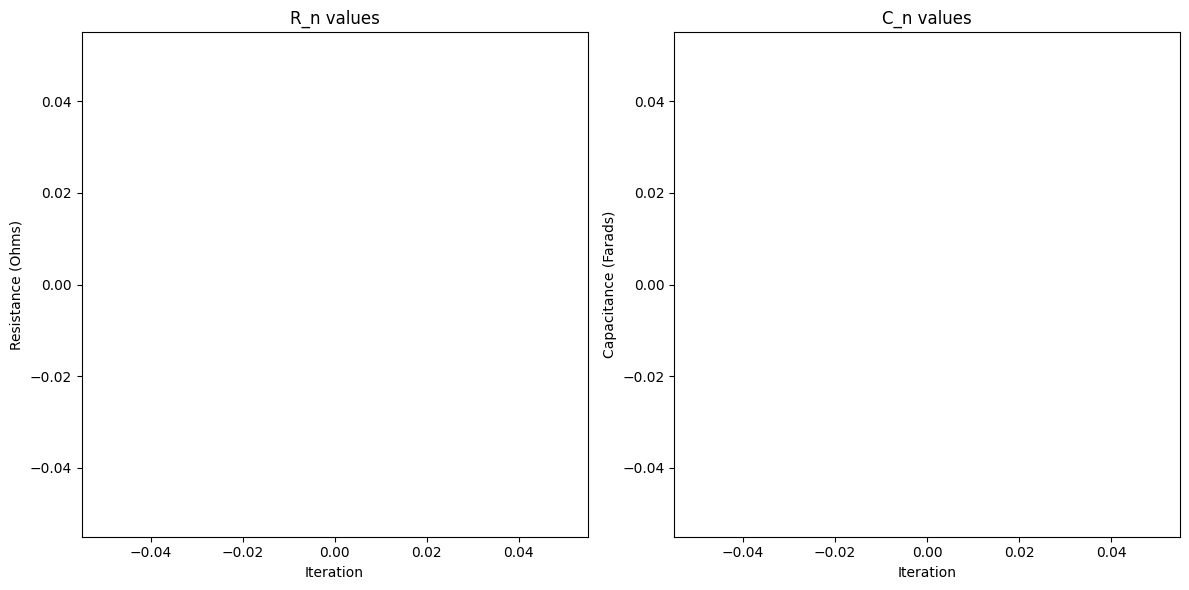

In [96]:
import matplotlib.pyplot as plt

# Plot R_n
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(R_samples)
plt.title('R_n values')
plt.xlabel('Iteration')
plt.ylabel('Resistance (Ohms)')

# Plot C_n
plt.subplot(1, 2, 2)
plt.plot(C_samples)
plt.title('C_n values')
plt.xlabel('Iteration')
plt.ylabel('Capacitance (Farads)')

plt.tight_layout()
plt.show()

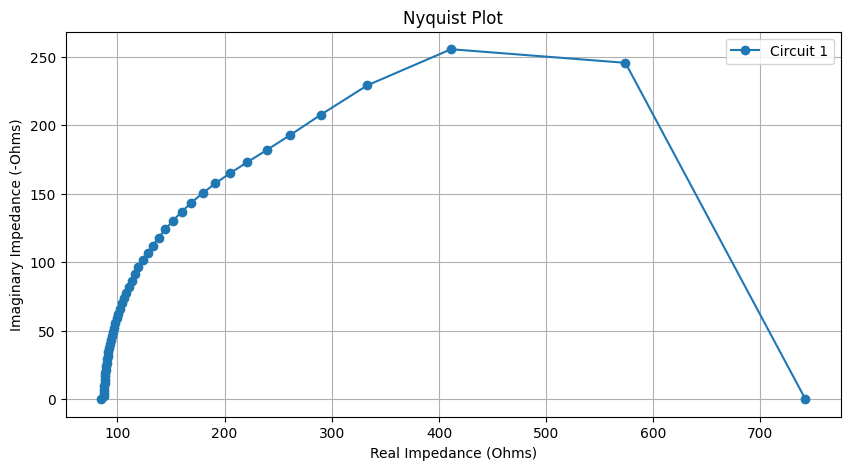

In [97]:
# Plot Nyquist plots
plt.figure(figsize=(10, 5))

# Circuit 1
plt.plot(data['Z_real'], -(data['Z_imag']), 'o-', label='Circuit 1')

# Circuit 2
#plt.plot(real_circuit2, -imag_circuit2, 's-', label='Circuit 2')

plt.title("Nyquist Plot")
plt.xlabel("Real Impedance (Ohms)")
plt.ylabel("Imaginary Impedance (-Ohms)")
plt.legend()
plt.grid()
plt.show()